# Packages

In [8]:
import importlib
 
if importlib.util.find_spec('fsspec') is None:
  !pip install fsspec
if importlib.util.find_spec('s3fs') is None:
  !pip install s3fs
if importlib.util.find_spec('pomegranate') is None:
    !pip install Cython
    !pip install pomegranate 

You should consider upgrading via the '/Users/jandespiegeleer/.pyenv/versions/3.6.10/envs/seminar_new/bin/python3.6 -m pip install --upgrade pip' command.
  Using cached pomegranate-0.13.5.tar.gz (4.5 MB)
  Created wheel for pomegranate: filename=pomegranate-0.13.5-cp36-cp36m-macosx_10_15_x86_64.whl size=7461125 sha256=4e7fa7b734c52fdc777851cf2912265433454815f22784499dae5117e2e3b962
  Stored in directory: /Users/jandespiegeleer/Library/Caches/pip/wheels/f8/44/d5/ef435c8691dccf338636f139732bc2a1694a51d745e8179fe0
Successfully built pomegranate
You should consider upgrading via the '/Users/jandespiegeleer/.pyenv/versions/3.6.10/envs/seminar_new/bin/python3.6 -m pip install --upgrade pip' command.


In [9]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
# add a warning suppressing
warnings.filterwarnings("ignore")

# Data EUR-GBP Exchange Rate last five years:

In [10]:
df = pd.read_excel('s3://lfspf/EURGBP.xlsx',index_col='date')
df.head()

,EURGBP
date,
2007-10-23,0.69575
2007-10-24,0.69550
2007-10-25,0.69765
2007-10-26,0.70100
2007-10-29,0.69895


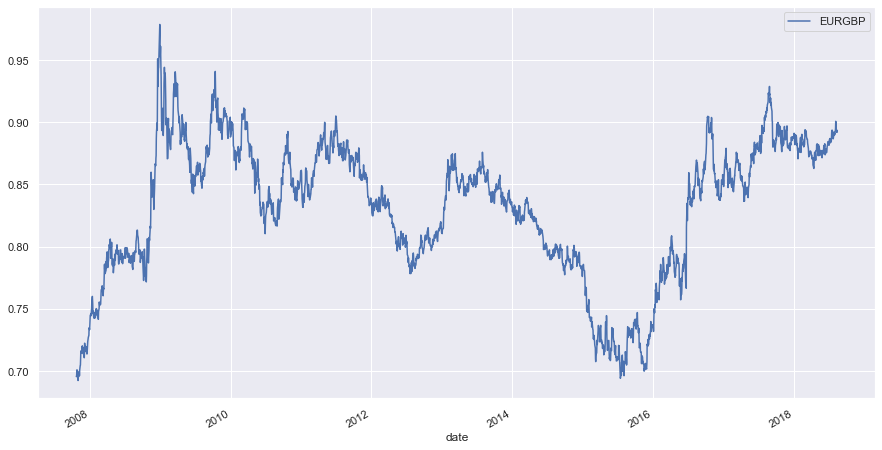

In [11]:
df.plot(figsize=(15,8))

# Returns of time series

In [12]:
df['Ret']= df['EURGBP'].pct_change(periods=1)
df.dropna(how='any',inplace=True)
X = df['Ret'].values.reshape(-1,1)

In [13]:
from pomegranate import hmm , NormalDistribution , State

<b>hmm.HiddenMarkovModel.from_samples</b>
This method will learn both the transition matrix, emission distributions, and start probabilities for each state. This will only return a dense graph without any silent states or explicit transitions to an end state. Currently all components must be defined as the same distribution, but soon this restriction will be removed.

If learning a multinomial HMM over discrete characters, the initial emisison probabilities are initialized randomly. If learning a continuous valued HMM, such as a Gaussian HMM, then kmeans clustering is used first to identify initial clusters.

Regardless of the type of model, the transition matrix and start probabilities are initialized uniformly. Then the specified learning algorithm (Baum-Welch recommended) is used to refine the parameters of the model.

In [14]:
# This method will learn both the transition matrix, emission distributions, 
# and start probabilities for each state. 
model = hmm.HiddenMarkovModel.from_samples(NormalDistribution, 
                                           n_components=2, 
                                           X=X,
                                           algorithm='viterbi')


# Transition Matrix

In [15]:
transition_matrix = model.forward_backward(X)[0][0:2,0:2]
v = np.sum(transition_matrix,0).T
transition_matrix = transition_matrix/v.reshape(-1,1)
print('Transition Matrix')
pd.DataFrame(transition_matrix)

Transition Matrix


,0,1
0,0.936501,0.063506
1,0.897059,0.102845


# Properties of the Regimes (emission)

In [16]:
Z = model.predict(X)
df_result = pd.DataFrame(Z)
df_result.columns = ['state']
df_result.index = df.index

idx_1 = df_result['state'] == 1
idx_0 = df_result['state'] == 0

First Regime

In [17]:
std = np.float(df.loc[idx_0,['Ret']].std())
mean = np.float(df.loc[idx_0,['Ret']].mean())
print('Regime 1:','Mean:',np.round(100*mean,3),'% Std:',np.round(100*std,3),'%')


Regime 1: Mean: -0.04 % Std: 0.496 %


Second Regime

In [18]:
std = np.float(df.loc[idx_1,['Ret']].std())
mean = np.float(df.loc[idx_1,['Ret']].mean())
print('Regime 2:','Mean:',np.round(100*mean,3),'% Std:',np.round(100*std,3),'%')


Regime 2: Mean: 1.547 % Std: 0.736 %
